#  Industry Entry-Exit Model


**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdp03.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2022-Oct-10</i>
<hr>

## About

A firm operates in an uncertain profit environment. At the beginning of each period, the firm observes its potential short-run operating profit over the coming period $\pi$, which may be negative, and decides whether to operate, making a short-run profit $\pi$, or not operate, making a short-run profit $0$. Although the firm faces no fixed costs, it incurs a shutdown cost $K_0$ when it closes and a start-up cost $K_1$ when it reopens. The short-run profit $\pi$ is an exogenous continuous-valued Markov process
\begin{equation}
    \pi_{t+1} = h(\pi_t, \epsilon_{t+1})
\end{equation}

**What is the optimal entry-exit policy?** In particular, how low must the short-run profit be for an operating firm to close, and how high must the short-run profit be for nonoperating firm to reopen? 

This is an infinite horizon, stochastic model with time $t$ measured in years. The state variables
\begin{align}
    \pi &\in (−\infty,\infty)\\
    d &\in \{0, 1\}
\end{align}

are the current short-run profit, a continuous variable, and the operational status of the firm, a binary variable that equals 1 if the firm is operating and 0 if the firm is not operating. The choice variable
\begin{equation}
    j \in \{0, 1\}
\end{equation}

is the operating decision for the coming year, a binary variable that equals 1 if the firm operates and 0 if does not operate. The state transition function is 
\begin{equation}
    g(\pi, d, j, \epsilon) = h(\pi, \epsilon), j)
\end{equation}

The reward function is
\begin{equation}
    f(\pi, d, j) = \pi j − K_1(1 − d)j − K_0 d(1 − j)
\end{equation}

The value of the firm, given that the current short-run profit is $\pi$ and the firm's operational status is $d$, satisfies the Bellman equation
\begin{equation}
    V(\pi,d) = \max_{j=0,1}\left\{\pi j − K_1(1−d)j − K_0d(1−j) + \delta E_\epsilon V\left(h(\pi,\epsilon),j\right)\right\}
\end{equation}


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import BasisSpline, DPmodel,qnwnorm

### The reward function

The reward function is
\begin{equation}
    f(\pi, d, j) = \pi j − K_1(1 − d)j − K_0 d(1 − j)
\end{equation}

 where the exit cost is $K_0=0$ and the entry cost is $K_1=10$.

In [2]:
K0     = 0.0
K1     = 10

def profit(p, x, d, j):
    return p * j - K1 * (1 - d) * j - K0 * d * (1 - j)

### The transition function

Assuming that the short-run profit $\pi$ is an exogenous Markov process 
\begin{equation}
    \pi_{t+1} = g(\pi_t,\epsilon_{t+1}) = \bar{\pi} + \gamma(\pi_t − \bar{\pi}) + \epsilon_{t+1}
\end{equation}    
where $\bar{\pi}=1.0$ and $\gamma=0.7$. 

In [3]:
pbar   = 1.0
gamma  = 0.7

def transition(p, x, d, j, in_, e):
    return pbar + gamma * (p - pbar) + e

In the transition function $\epsilon_t$ is an i.i.d. normal(0, $σ^2$), with $\sigma=1$. We discretize this distribution by using a discrete distribution, matching the first 10 moments of the normal distribution.

In [4]:
m = 5  # number of profit shocks
sigma  = 1.0
[e,w] = qnwnorm(m,0,sigma **2)

The collocation method calls for the analyst to select $n$ basis functions $\varphi_j$ and $n$ collocation nodes $(\pi_i,d_i)$, and form the value function approximant $V(\pi,d) \approx \sum_{j=1}^{n} c_j\varphi_j(\pi,d)$ whose coefficients $c_j$ solve the collocation equation

\begin{equation}
    \sum_{j=1}^{n} c_j\varphi_j(\pi_i,d_i) = \max_{x\in\{0,1\}}\left\{\pi_i x − K_1(1−d_i)x − K_0 d_i(1−x) + \delta\sum_{k=1}^{m}\sum_{j=1}^{n}w_k c_j \varphi_j(\hat{\pi}_{ik},x)\right\}
\end{equation}

where $\hat\pi_{ik}=g(\pi_i,\epsilon_k)$ and where $\epsilon_k$ and $w_k$ represent quadrature nodes and weights for
the normal shock.

For the approximation, we use a cubic spline basis with $n=250$ nodes between $p_\text{min}=-20$ and $p_\text{max}=20$.

In [5]:
n = 250
pmin = -20
pmax =  20
basis = BasisSpline(n, pmin, pmax, labels=['profit'])
print(basis)

A 1-dimension Cubic spline basis:  using 250 Canonical nodes and 250 polynomials
___________________________________________________________________________
	profit: 250 nodes in [-20.00,  20.00]

WARNING! Class Basis is still work in progress


Discrete states and discrete actions are

In [6]:
dstates = ['idle', 'active']
dactions = ['close', 'open']

The Bellman equation is represeted by a ```DPmodel``` object, where we assume a discount factor of $\delta=0.9$. Notice that the discrete state transition is deterministic, with transition matrix 
\begin{equation}
    h=\begin{bmatrix}0&0\\1&1\end{bmatrix}
\end{equation}   

In [7]:
model = DPmodel(basis,
                profit, transition,
                i=dstates,
                j=dactions,
                discount=0.9, e=e, w=w,
                h=[[0, 0], [1, 1]])

## SOLUTION

To solve the model, we simply call the ```solve``` method on the ```model``` object.

In [8]:
S = model.solve(show=True)
S.head()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       6.0e+01    0.0965
   1       3.2e+01    0.1649
   2       2.9e+00    0.2309
   3       4.3e-01    0.3035
   4       4.9e-14    0.3886
Elapsed Time =    0.39 Seconds


profit  i     value         resid     j*  value[close]  \
     profit                                                                  
idle -20.000000 -20.000000  0  0.894342 -1.110223e-16  close      0.894342   
     -19.983994 -19.983994  0  0.894542 -5.251344e-11  close      0.894542   
     -19.967987 -19.967987  0  0.894743 -5.991030e-11  close      0.894743   
     -19.951981 -19.951981  0  0.894943 -2.191858e-11  close      0.894943   
     -19.935974 -19.935974  0  0.895144  4.235901e-11  close      0.895144   

                 value[open]  
     profit                   
idle -20.000000   -29.105658  
     -19.983994   -29.089452  
     -19.967987   -29.073245  
     -19.951981   -29.057038  
     -19.935974   -29.040830

### Plot Action-Contingent Value Functions

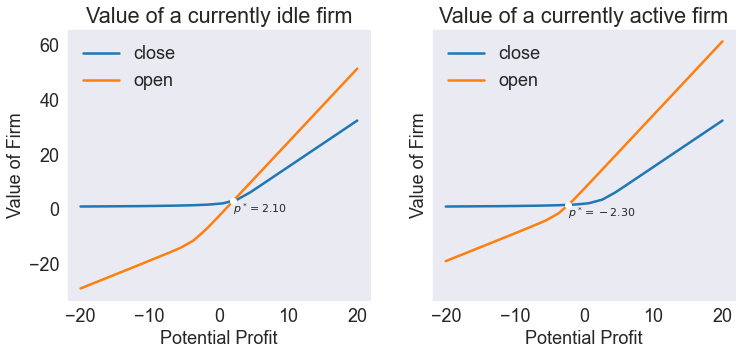

In [9]:
fig1,axs = plt.subplots(1,2,sharey=True, figsize=[12,5])

msgs = ['Profit Entry', 'Profit Exit']

for ax, state in zip(axs, dstates):
    subdata = S.loc[state, ['value[close]', 'value[open]']]
    ax.plot(subdata)
    ax.set(title= f"Value of a currently {state} firm",
           xlabel='Potential Profit',
           ylabel='Value of Firm')
    
    ax.legend(dactions)
    
    subdata['v.diff'] = subdata['value[open]'] - subdata['value[close]']
    pcrit = np.interp(0, subdata['v.diff'], subdata.index)
    vcrit  = np.interp(pcrit, subdata.index, subdata['value[close]'])
    
    ax.plot(pcrit, vcrit, 'wo')
    ax.annotate(f'$p^* = {pcrit:.2f}$', [pcrit, vcrit], fontsize=11, va='top')
    

### Plot Residual

We normalize the residuals as percentage of the value function. Notice the spikes at the "Profit entry" and "Profit exit" points.

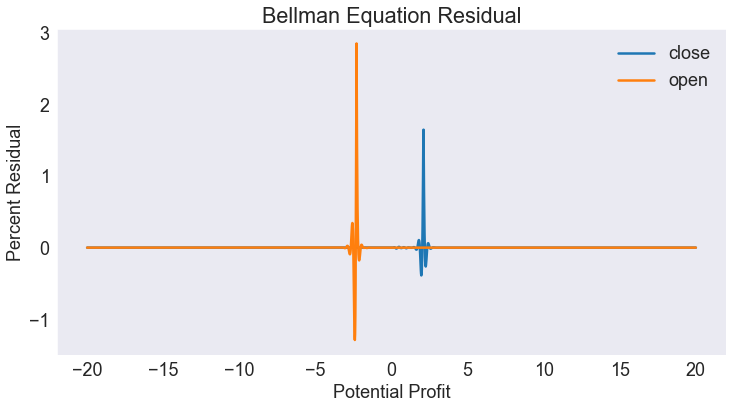

In [10]:
S['resid2'] = 100 * (S.resid / S.value)

fig2, ax = plt.subplots()

ax.plot(S['resid2'].unstack(level=0))
ax.set(title='Bellman Equation Residual',
       xlabel='Potential Profit',
       ylabel='Percent Residual')
       
ax.legend(dactions);

## SIMULATION

We simulate the model 50000 times for a time horizon $T=50$, starting with an operating firm ($d=1$) at the long-term profit mean $\bar{\pi}$. To be able to reproduce these results, we set the random seed at an arbitrary value of 945.

In [11]:
T = 50
nrep = 50000
p0 = np.tile(pbar, (1, nrep))
d0 = 1
data = model.simulate(T, p0, d0, seed=945)

### Print Ergodic Moments

In [12]:
ergodic = pd.DataFrame({
    'Ergodic Means' : [data['profit'].mean(), (data['i'] == 'active').mean()],
    'Ergodic Standard Deviations': [data['profit'].std(), (data['i'] == 'active').std()]},
    index=['Profit Contribution', 'Activity'])

ergodic.round(2)

,Ergodic Means,Ergodic Standard Deviations
Profit Contribution,1.00,1.37
Activity,0.94,0.24


### Plot Simulated and Expected Continuous State Path

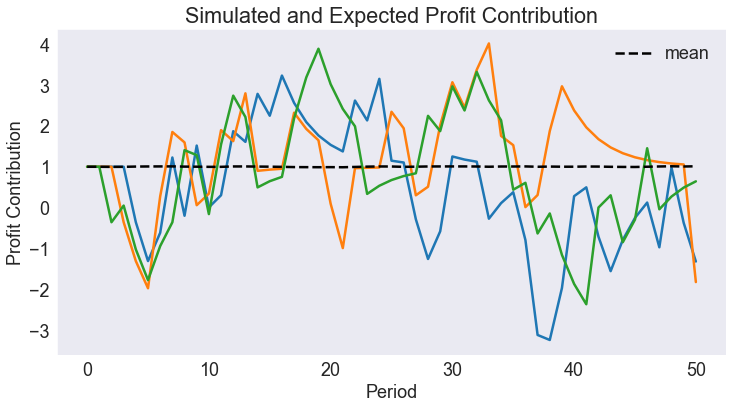

In [13]:
subdata = data.query("_rep < 3").set_index(["time", "_rep"]).unstack()

fig3, ax = plt.subplots()

ax.plot(subdata["profit"])
ax.set(title='Simulated and Expected Profit Contribution', 
       xlabel='Period',
       ylabel='Profit Contribution')

ax.plot(data[['time','profit']].groupby('time').mean(),'k--',label='mean')
ax.legend();

### Plot Expected Discrete State Path

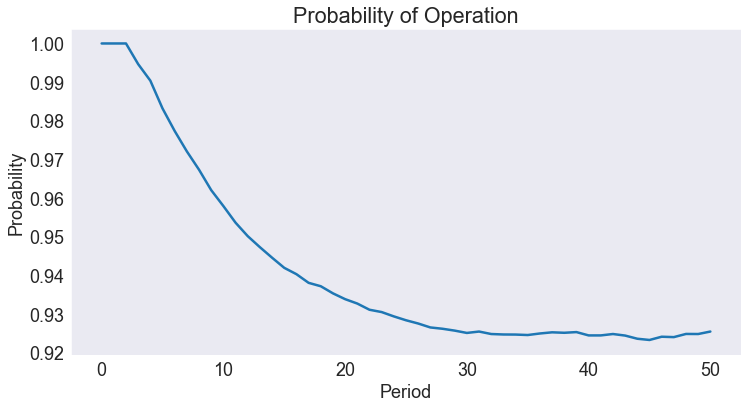

In [14]:
data['ii'] = data['i'] == 'active'
probability_of_active = data[['time','ii']].groupby('time').mean()

fig4, ax = plt.subplots()

ax.plot(probability_of_active)
ax.set(title='Probability of Operation', 
       xlabel='Period', 
       ylabel='Probability');